<a href="https://colab.research.google.com/github/zindaachmad/uas-bigdata-housing/blob/main/23_11_5852_UAS_Big_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UAS Big Data - Prediksi Harga Rumah California
**Nama:** ZINDA ACHMAD MUZAKI
**NIM:** 23.11.5852
**Kelas:** 23IF08

## 1. Persiapan Data & Storage Dataset diambil dari GitHub (California Housing) yang memenuhi syarat 3V (Volume, Variety, Value) dan dimuat ke dalam simulasi HDFS menggunakan Spark DataFrame.

In [1]:
# ==========================================
# BAGIAN 1: INSTALASI SPARK (ENVIRONMENT)
# ==========================================
import os

# 1. Install Java & Download Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

# 2. Setup Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

# 3. Inisialisasi Spark Session
import findspark
findspark.init()
from pyspark.sql import SparkSession

# Membuat sesi Spark (Ibarat menyalakan mesin Big Data)
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("UAS_BigData_Housing") \
    .getOrCreate()

In [2]:
!wget -q https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv -O housing_data.csv

print("Dataset berhasil didownload dari GitHub!")

Dataset berhasil didownload dari GitHub!


In [3]:
df = spark.read.csv("housing_data.csv", header=True, inferSchema=True)

print("Data berhasil dimuat ke Spark!")
print("-" * 30)

# Menampilkan Struktur Data (Schema)
df.printSchema()

# Menampilkan 5 baris pertama untuk pengecekan
df.show(5)

Data berhasil dimuat ke Spark!
------------------------------
root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     3

## 2. Pemrosesan Big Data (EDA & Preprocessing) Dilakukan pengecekan missing values, imputasi data kosong pada kolom 'total_bedrooms', serta analisis distribusi data.

--- Statistik Deskriptif ---
+-------+------------------+------------------+------------------+
|summary|       total_rooms|     median_income|median_house_value|
+-------+------------------+------------------+------------------+
|  count|             20640|             20640|             20640|
|   mean|2635.7630813953488|3.8706710029070246|206855.81690891474|
| stddev|2181.6152515827944| 1.899821717945263|115395.61587441359|
|    min|               2.0|            0.4999|           14999.0|
|    max|           39320.0|           15.0001|          500001.0|
+-------+------------------+------------------+------------------+

--- Pengecekan Missing Values ---
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+------

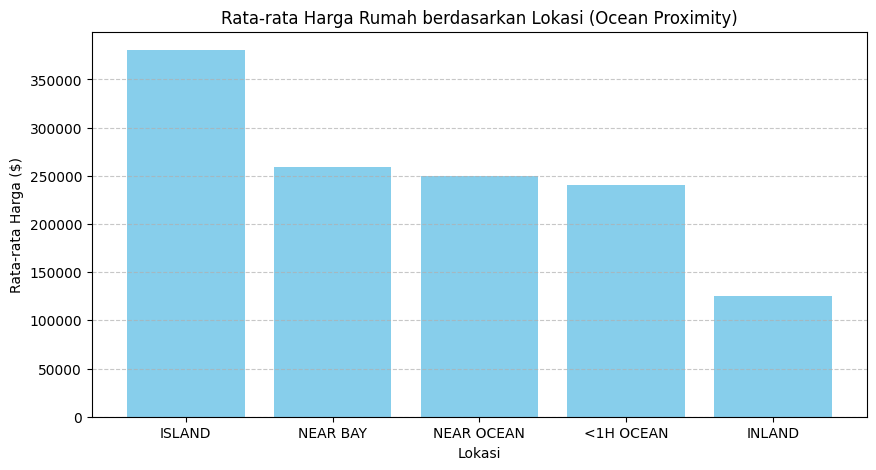

In [4]:
# ==========================================
# PEMROSESAN DATA
# ==========================================

from pyspark.sql.functions import col, mean, when

# --- 1. EDA (Exploratory Data Analysis) - Soal 3b ---
print("--- Statistik Deskriptif ---")
# describe() menghitung count, mean, stddev, min, max untuk tiap kolom
df.select("total_rooms", "median_income", "median_house_value").describe().show()

# Cek apakah ada nilai kosong (Missing Values)
print("--- Pengecekan Missing Values ---")
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# --- 2. PREPROCESSING (Handling Missing Value) - Soal 3c ---

# Hitung rata-rata total_bedrooms
avg_bedrooms = df.select(mean(col('total_bedrooms'))).collect()[0][0]
print(f"Rata-rata total bedrooms: {avg_bedrooms:.2f}")

# Isi nilai null dengan rata-rata tersebut
df_clean = df.na.fill(avg_bedrooms, ["total_bedrooms"])

print("Data kosong pada 'total_bedrooms' telah diisi.")

# --- 3. MANIPULASI DATA (Spark SQL) - Soal 3d ---
df_clean.createOrReplaceTempView("housing_data")

print("--- Rata-rata Harga Rumah per Lokasi (via Spark SQL) ---")
sql_query = """
    SELECT
        ocean_proximity,
        ROUND(AVG(median_house_value), 2) as avg_price,
        COUNT(*) as total_houses
    FROM housing_data
    GROUP BY ocean_proximity
    ORDER BY avg_price DESC
"""
result_sql = spark.sql(sql_query)
result_sql.show()

# --- 4. VISUALISASI DATA - Soal 3b ---
import matplotlib.pyplot as plt
import pandas as pd

# Convert hasil SQL ke Pandas DataFrame
pdf = result_sql.toPandas()

# Membuat Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(pdf['ocean_proximity'], pdf['avg_price'], color='skyblue')
plt.title('Rata-rata Harga Rumah berdasarkan Lokasi (Ocean Proximity)')
plt.xlabel('Lokasi')
plt.ylabel('Rata-rata Harga ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3. Implementasi RDD & MapReduce Menggunakan teknik MapReduce manual untuk menghitung rata-rata harga rumah berdasarkan lokasi, sebagai alternatif dari SQL query.

In [5]:
# ==========================================
# BAGIAN 5: SOAL 3a & 3e (RDD & MAPREDUCE)
# ==========================================

# 1. Mengubah DataFrame yang sudah bersih menjadi RDD
# RDD adalah format data mentah yang terdistribusi
rdd_housing = df_clean.rdd

# --- PROSES MAP (Pemetaan) ---
# Angka 1 digunakan untuk menghitung jumlah data nanti (counter).
mapped_rdd = rdd_housing.map(lambda row: (row['ocean_proximity'], (row['median_house_value'], 1)))

# --- PROSES REDUCE (Pengurangan/Agregasi) ---
# x dan y adalah dua data yang sedang digabungkan.
# x[0] + y[0] = Menjumlahkan harga rumah
# x[1] + y[1] = Menjumlahkan counter (jumlah rumah)
reduced_rdd = mapped_rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

# --- PROSES FINAL (Menghitung Rata-rata) ---
# Sekarang datanya berbentuk: ('ISLAND', (Total_Harga, Total_Jumlah))
result_rdd = reduced_rdd.mapValues(lambda x: x[0] / x[1])

# --- MENAMPILKAN HASIL ---
print("--- Hasil Perhitungan Rata-rata via RDD MapReduce ---")
results = result_rdd.collect()

for location, avg_price in results:
    print(f"Lokasi: {location} \t| Rata-rata Harga: ${avg_price:,.2f}")

--- Hasil Perhitungan Rata-rata via RDD MapReduce ---
Lokasi: NEAR BAY 	| Rata-rata Harga: $259,212.31
Lokasi: <1H OCEAN 	| Rata-rata Harga: $240,084.29
Lokasi: INLAND 	| Rata-rata Harga: $124,805.39
Lokasi: NEAR OCEAN 	| Rata-rata Harga: $249,433.98
Lokasi: ISLAND 	| Rata-rata Harga: $380,440.00


## 4. Pemodelan Machine Learning & Evaluasi Membandingkan algoritma Linear Regression dan Random Forest. Evaluasi dilakukan menggunakan RMSE dan R2 Score.

In [6]:
# ==========================================
# BAGIAN 6: SOAL 4 & 6 (MODELING & EVALUASI)
# ==========================================
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# --- 1. FEATURE ENGINEERING ---
# Mengubah kolom kategori 'ocean_proximity' menjadi angka
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_index")

# Menggabungkan semua kolom input menjadi satu kolom vektor bernama 'features'
# Target kita adalah 'median_house_value'
feature_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income', 'ocean_index']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# --- 2. SPLITTING DATA ---
# Membagi data: 80% untuk Latihan (Training), 20% untuk Ujian (Testing)
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)

print(f"Data Training: {train_data.count()} baris")
print(f"Data Testing : {test_data.count()} baris")

# --- 3. MENDEFINISIKAN MODEL ---
# Model A: Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="median_house_value")

# Model B: Random Forest (Biasanya lebih akurat untuk data kompleks)
rf = RandomForestRegressor(featuresCol="features", labelCol="median_house_value", numTrees=20)

# --- 4. TRAINING & PREDIKSI (PIPELINE) ---

# Pipeline A: Linear Regression
pipeline_lr = Pipeline(stages=[indexer, assembler, lr])
model_lr = pipeline_lr.fit(train_data)           # Latih model
pred_lr = model_lr.transform(test_data)          # Prediksi data ujian

# Pipeline B: Random Forest
pipeline_rf = Pipeline(stages=[indexer, assembler, rf])
model_rf = pipeline_rf.fit(train_data)           # Latih model
pred_rf = model_rf.transform(test_data)          # Prediksi data ujian

# --- 5. EVALUASI MODEL (Soal 6) ---
# RMSE (Root Mean Squared Error) - Semakin kecil semakin bagus
# Dan R2 (R-Squared) - Semakin mendekati 1 semakin akurat
evaluator_rmse = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")

# Hitung error Linear Regression
rmse_lr = evaluator_rmse.evaluate(pred_lr)
r2_lr = evaluator_r2.evaluate(pred_lr)

# Hitung error Random Forest
rmse_rf = evaluator_rmse.evaluate(pred_rf)
r2_rf = evaluator_r2.evaluate(pred_rf)

print("\n" + "="*40)
print("HASIL KOMPARASI MODEL (SOAL 4 & 6)")
print("="*40)
print(f"1. Linear Regression:")
print(f"   - RMSE (Error): {rmse_lr:,.2f}")
print(f"   - R2 Score    : {r2_lr:.4f}")
print("-" * 20)
print(f"2. Random Forest:")
print(f"   - RMSE (Error): {rmse_rf:,.2f}")
print(f"   - R2 Score    : {r2_rf:.4f}")
print("="*40)

if rmse_rf < rmse_lr:
    print("KESIMPULAN: Random Forest lebih baik!")
else:
    print("KESIMPULAN: Linear Regression lebih baik!")

Data Training: 16560 baris
Data Testing : 4080 baris

HASIL KOMPARASI MODEL (SOAL 4 & 6)
1. Linear Regression:
   - RMSE (Error): 71,796.88
   - R2 Score    : 0.6274
--------------------
2. Random Forest:
   - RMSE (Error): 70,383.65
   - R2 Score    : 0.6420
KESIMPULAN: Random Forest lebih baik!


In [7]:
## 5. Hyperparameter Tuning Melakukan optimasi model Random Forest menggunakan Grid Search untuk mencari kombinasi parameter terbaik.

In [8]:
# ==========================================
# BAGIAN 7: SOAL 5 (HYPERPARAMETER TUNING)
# ==========================================
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

print("Mulai proses Tuning... ")

# 1. Tentukan Grid (Kombinasi Settingan yang mau dicoba)
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# 2. Siapkan Cross Validator
# Ini akan membagi data latih menjadi 3 bagian (3-fold) untuk validasi silang
crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_rmse,
                          numFolds=3)

# 3. Jalankan Training (Mencari Model Terbaik)
cvModel = crossval.fit(train_data)

# 4. Ambil Model Terbaik
best_model = cvModel.bestModel

# 5. Prediksi ulang menggunakan Model Terbaik
predictions_best = best_model.transform(test_data)

# 6. Evaluasi Hasil Akhir
rmse_best = evaluator_rmse.evaluate(predictions_best)
r2_best = evaluator_r2.evaluate(predictions_best)

print("\n" + "="*40)
print("HASIL AKHIR SETELAH TUNING (SOAL 5)")
print("="*40)
print(f"RMSE Awal (Sebelum Tuning) : {rmse_rf:,.2f}")
print(f"RMSE Terbaik (Setelah Tuning): {rmse_best:,.2f}")
print(f"Peningkatan Akurasi (R2)   : {r2_best:.4f}")
print("-" * 20)

# Menampilkan Parameter Terbaik
best_rf_model = best_model.stages[-1] # Mengambil tahap terakhir (RF) dari pipeline
print(f"Best NumTrees: {best_rf_model.getNumTrees}")
print(f"Best MaxDepth: {best_rf_model.getMaxDepth}")
print("="*40)

Mulai proses Tuning... 

HASIL AKHIR SETELAH TUNING (SOAL 5)
RMSE Awal (Sebelum Tuning) : 70,383.65
RMSE Terbaik (Setelah Tuning): 56,437.39
Peningkatan Akurasi (R2)   : 0.7698
--------------------
Best NumTrees: 50
Best MaxDepth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestRegressionModel: uid=RandomForestRegressor_d62e14351e57, numTrees=50, numFeatures=9>
